In [1]:
import cv2
import numpy as np
import PIL
from math import pi
import math
from matplotlib import pyplot as plt
import random
from tqdm import tqdm
from sklearn.cluster import DBSCAN
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import skimage.io
from scipy import ndimage as ndi
from statistics import mean

print("Done")

Done


In [2]:
def do_image(sel, R, G, B, alpha_chan = [], thresh = 55):
    # original = cv2.cvtColor(cv2.imread("download.png"), cv2.COLOR_BGR2RGB)
    target = np.array([R, G, B, 255])
    m = np.shape(sel)[0]
    n = np.shape(sel)[1]
    
    def make_palette(color,shape):
        out = np.zeros(shape)
        m = shape[0]
        n = shape[1]
        for i in range(m):
            for j in range(n):
                out[i,j,:] = color
        return out.astype('uint8')
    
    def check_pixel(current, target, bound):
        x = current.astype('int8')
        t = target.astype('int8')
        
        if np.max(np.abs(x-t)) < bound:
            return True
        else:
            return False
    
    if len(alpha_chan) == 0:
        for i in range(m):
            for j in range(n):
                if check_pixel(sel[i,j,:],target,thresh):
                    sel[i,j,3] = 0
                else:
                    pass
        return cv2.split(sel)[:2], cv2.split(sel)[3]
    else:
        r_channel, g_channel, b_channel, _ = cv2.split(sel)
        img_BGRA = cv2.merge((r_channel, g_channel, b_channel, alpha_chan))
        return img_BGRA, alpha_chan

def weight_func(imageA, imageB):
    # the 'Mean Squared Error' between the two alpha channels is the
    # sum of the squared difference between the two images;
    # NOTE: the two images must have the same dimension

    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])

    # return the MSE, the lower the error, the more "similar"
    # the two images are
    return err

print("Done")

Done


Target:


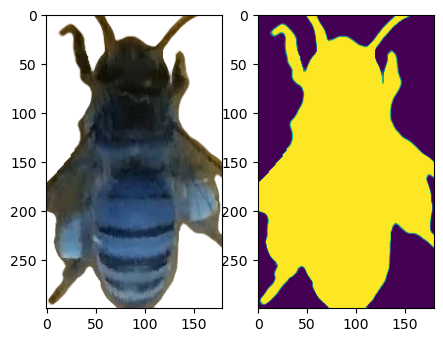

Starting sum: 38414


Monte Carlo Param Search::   0%|                    | 4/2500 [00:02<28:24,  1.46iteration/s, Best=3.84e+4, Sum=4.02e+4]

KeyboardInterrupt



In [4]:
reference_img = cv2.cvtColor(cv2.imread("blue_reference_img.png"), cv2.COLOR_BGR2RGB)
reference_img = cv2.cvtColor(cv2.imread("blue_reference_img.png"), cv2.COLOR_RGB2RGBA)
#reference_alpha = cv2.bitwise_not(cv2.cvtColor(cv2.imread("blue_reference_alpha.png"), cv2.COLOR_BGR2GRAY)) # this manipulates the reference alpha (soft lined)
reference_alpha = cv2.cvtColor(cv2.imread("blue_reference_alpha.png"), cv2.COLOR_BGR2GRAY) # this manipulates the reference alpha (soft lined)


starting_params = [40, 101, 130, [], 55]
img1, alpha1 = do_image(reference_img, *starting_params)
# reference image w/ reference alpha
img2, alpha2 = do_image(reference_img,
                        starting_params[0],
                        starting_params[1],
                        starting_params[2],
                        alpha_chan = reference_alpha,
                        thresh = starting_params[4],
                       )
print("Target:")
fig, axs = plt.subplots(ncols = 2, figsize=(5, 5))
axs[0].imshow(img2)
axs[1].imshow(alpha2)
for ax in axs:
    plt.show()
start_running_sum = weight_func(alpha1, alpha2)
print("Starting sum: %d" % (start_running_sum))
best_params = starting_params
best_sum = start_running_sum

k = 0
iters = 2500#000
with tqdm(total=iters, unit="iteration", desc=str("Monte Carlo Param Search:")) as pbar:
    while k < iters:
        thresh = random.randint(1,255) # default == 255
        #thresh_lo = random.randint(0, thresh_hi) # default == 0
        # erode_val = random.randint(0, 30) # default == 3
        # gauss_val = random.choice([1, 3, 5, 7, 9])
        # exponent = random.randint(10, 10000) / 1000
        # gauss_val2 = random.choice([1, 3, 5, 7, 9])
        R = random.randint(0, 255)
        G = random.randint(0, 255)
        B = random.randint(0, 255)
        new_params = [R, G, B, [], thresh]#, thresh_hi, erode_val, gauss_val, exponent, gauss_val2]
        img3, markers = do_image(reference_img, *new_params)
        new_running_sum = weight_func(markers, alpha2)
        if new_running_sum < best_sum:
            best_sum = new_running_sum
            best_params = new_params
            fig, axs = plt.subplots(ncols = 2, figsize=(5, 5))
            axs[0].imshow(img3)
            axs[1].imshow(markers)
            for ax in axs:
                plt.show()
            print(best_params)
        k = k + 1
        pbar.set_postfix(Sum = new_running_sum, Best = best_sum, refresh=True)
        pbar.update(1)

new_img, new_alpha = do_image(reference_img, *best_params)
fig, axs = plt.subplots(ncols = 4, figsize=(15, 15))
axs[0].imshow(reference_img)
axs[1].imshow(reference_alpha)
axs[2].imshow(new_img)
axs[3].imshow(new_alpha)
for ax in axs:
    plt.show()
new_running_sum = weight_func(alpha2, new_alpha)
print(new_running_sum)
print(*best_params)